# PROJECT: E-COMMERCE SENTIMENT ANALYSIS FOR CUSTOMER REVIEWS

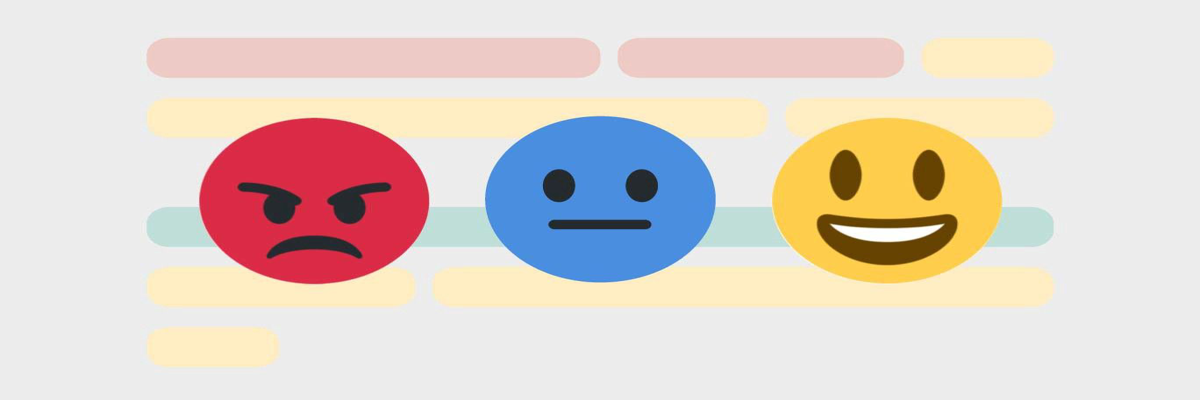

In [1]:
from PIL import Image
Image.open('emotion.jpeg').resize((1200,400))

# Table of Contents:
---
1. [Introduction](#Task-1)

2. [Data Preprocessing and Feature Engineering](#Task-2)

3. [Exploratory Data Analysis (EDA)](#Task-3)

4. [Features Extraction for Model Building](#Task-4)

5. [Sentiment Model Building](#Task-5)

6. [Conclusion](#Task-6)
---


<a id="Task-1"></a>
# 1. Introduction:
In today's world, we encounter a multitude of products and services, especially online. When making a choice, customer reviews play a crucial role. Ratings offer a quick overview, but understanding the sentiment in sentence reviews is equally important. With advancements in Natural Language Processing (NLP) technology, we can now easily extract insights from these reviews, helping consumers make informed decisions.


## What is Sentiment Analysis
Sentiment analysis, also known as opinion mining, is a natural language processing (NLP) technique used to determine the sentiment or emotional tone expressed in a piece of text. It involves analyzing text data, such as reviews, social media posts, or customer feedback, to determine whether the sentiment expressed is positive, negative, neutral, or even more nuanced emotions like joy, anger, sadness, etc. The primary goal of sentiment analysis is to automatically classify and understand the subjective information in text data.


## Project Objective:
* Collect customer review data from selected e-commerce sites - Amazon.com
* Analyze sentiment trends across different porduct categories.
* Develop sentiment analysis model to classify reviews as positive, negative, and neutral.

## Import of Libraries

In [2]:
# Data Analysis and Visualiztion Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import missingno as msno 
%matplotlib inline

# NLP Libraries
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Model building Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

## Import of dataset
**Dataset was scraped from Amazon.com**

In [3]:
df = pd.read_csv('amazon_data.csv')
df.head(3)

,Customer_i_ID,Customer_i_Star_Rating,Customer_i_Comment,Customer_i_buying_influence,Customer_i_Date,product,category,price_dollars,total_ratings
0,R2XDX5EDQSDK1F,5.0,Fantastic,0.0,10/21/2023,Five Nights at Freddy's: The Core Collection (...,video_games,19.93,4788
1,RRUZC22ZU7FTB,5.0,Bueno,0.0,10/25/2023,Super Smash Bros. Ultimate - US Version,video_games,50.55,68875
2,R3O181F9WBJWYS,4.0,"Quality product, good price!",0.0,10/25/2023,BIC Xtra-Smooth Mechanical Pencils with Eraser...,video_games,0.25,40996


## Data Assessment

In [4]:
# Check data dimensionality
rows, columns = df.shape
print('Number of rows:', rows)
print('Number of columns:', columns)

Number of rows: 18210
Number of columns: 9


In [5]:
# Display information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18210 entries, 0 to 18209
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_i_ID                18210 non-null  object 
 1   Customer_i_Star_Rating       15347 non-null  float64
 2   Customer_i_Comment           18127 non-null  object 
 3   Customer_i_buying_influence  15347 non-null  float64
 4   Customer_i_Date              18210 non-null  object 
 5   product                      18210 non-null  object 
 6   category                     18210 non-null  object 
 7   price_dollars                18210 non-null  float64
 8   total_ratings                18210 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 1.3+ MB


<a id="Task-2"></a>
# 2. Data Preprocessing and Feature Engineering

## Renaming of features
* This is done for clarity and easy readability of feature names.

In [6]:
df.rename(columns={"Customer_i_ID":"Cutomer_ID", "Customer_i_Star_Rating":"Rating", "Customer_i_Comment":"Review",
                   "Customer_i_buying_influence":"Customer_Influence", "Customer_i_Date":"Date", "product":"Product", "category":"Category",
                   "price_dollars":"Price", "total_ratings":"Total_Rating"}, inplace=True)

df.head(2)

,Cutomer_ID,Rating,Review,Customer_Influence,Date,Product,Category,Price,Total_Rating
0,R2XDX5EDQSDK1F,5.0,Fantastic,0.0,10/21/2023,Five Nights at Freddy's: The Core Collection (...,video_games,19.93,4788
1,RRUZC22ZU7FTB,5.0,Bueno,0.0,10/25/2023,Super Smash Bros. Ultimate - US Version,video_games,50.55,68875


## Handling of duplicates
* This step is to remove all duplicated rows.

In [7]:
# Check for duplicates
dup = df.duplicated().sum()
print(f"Duplicated rows: {dup}")

Duplicated rows: 3889


In [8]:
# Dropping of duplicated rows
df.drop_duplicates(inplace=True)

## Handling of null values
* Rows with null values will be removed and not replaced, inorder to maintain data integrity and also there are enough rows even after removal of null values

In [9]:
# Check for null values
df.isnull().sum()

Cutomer_ID              0
Rating                718
Review                 75
Customer_Influence    718
Date                    0
Product                 0
Category                0
Price                   0
Total_Rating            0
dtype: int64

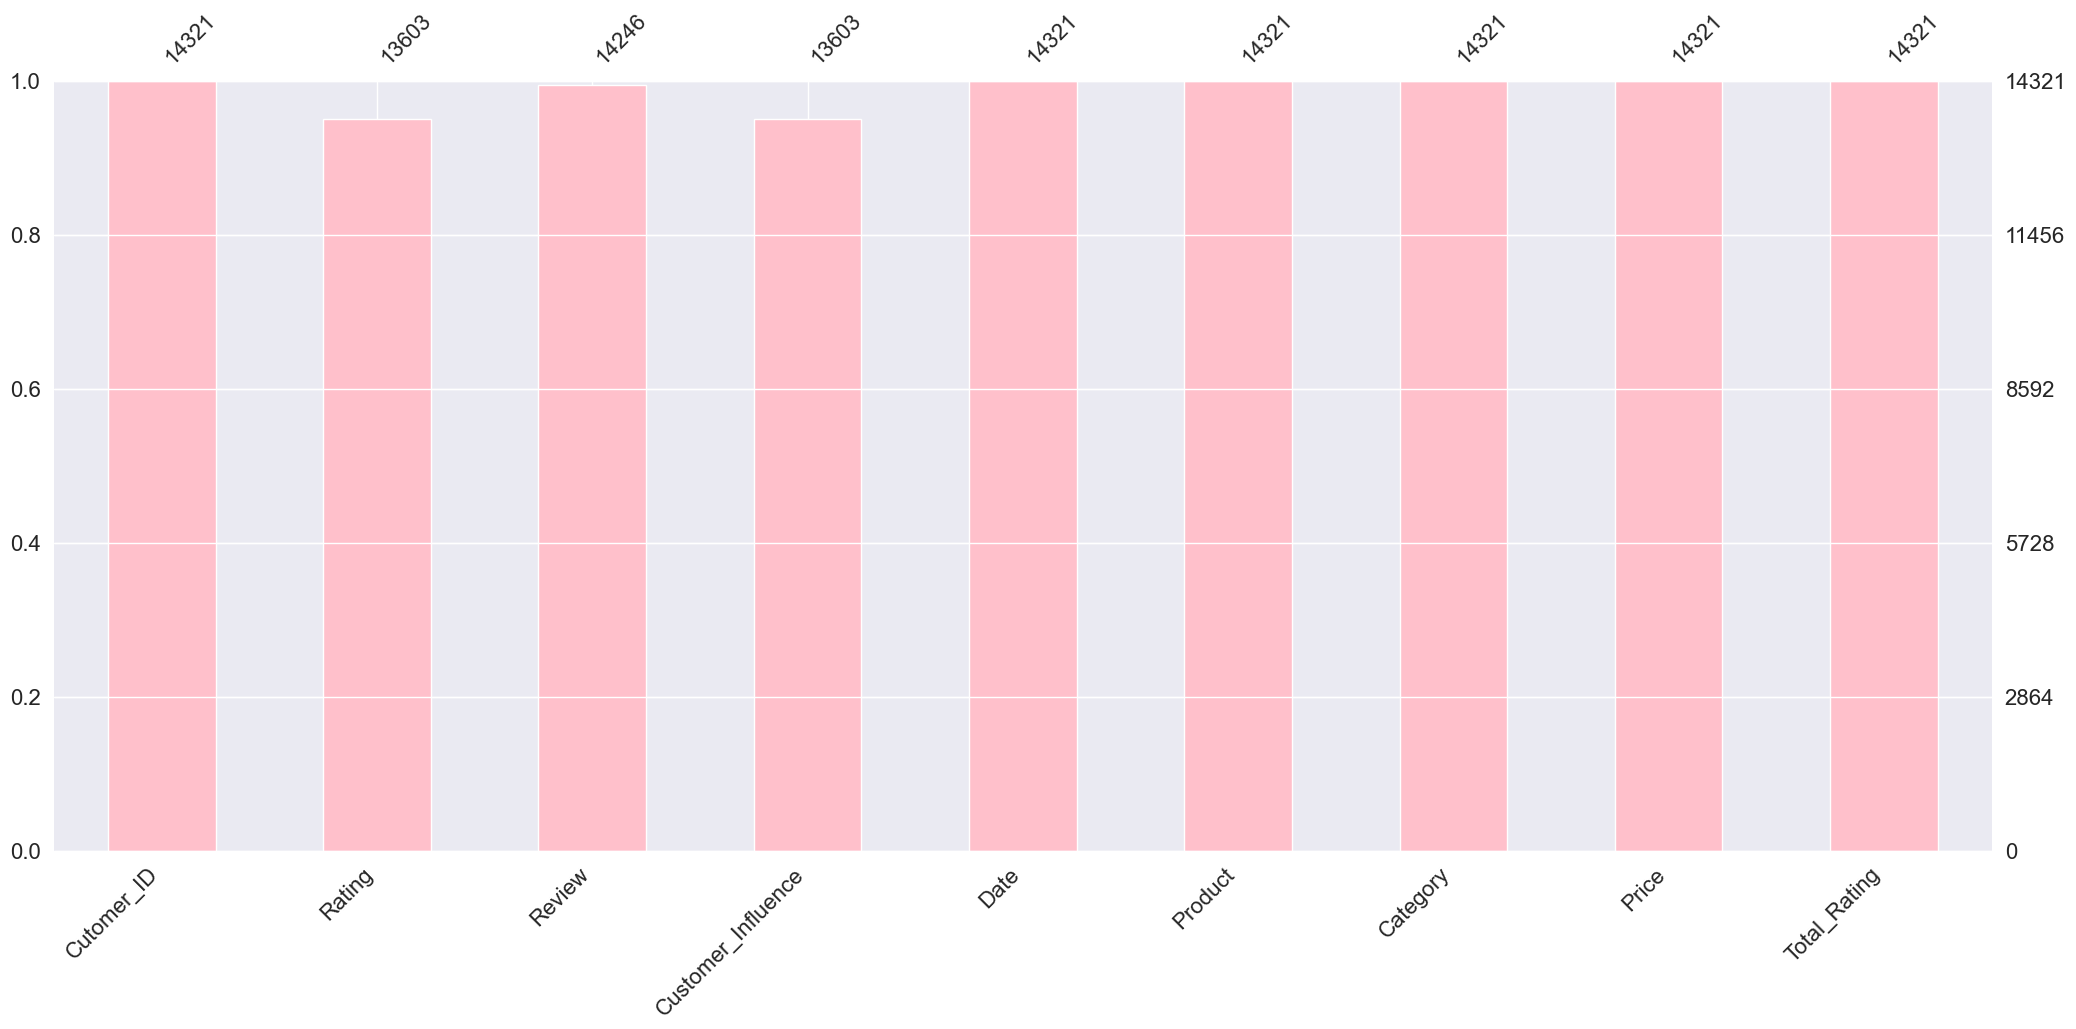

In [10]:
# Visualization of missing values
msno.bar(df, color='pink');

In [11]:
# Drop all null values:
df.dropna(inplace=True)

## Handling of date column
* Target here is convert Date column into Datetime and split the column into year, month and day. Also, some dates have OutOfBoundDatetime of "1677-09-21" which will be filtered out.

In [12]:
# Rows with 'OutOfBoundDatetime': this rows don't have 0 rating and non-english reviews
df[df["Date"] == "1677-09-21"].iloc[10:13]

,Cutomer_ID,Rating,Review,Customer_Influence,Date,Product,Category,Price,Total_Rating
1119,R2OSGO4UH8JA5T,0.0,Tres solide correspond aux attentes demandées!,0.0,1677-09-21,"Blackview Rugged Smartphone Unlocked, 2023 BV6...",Smartphones,0.0,3
1124,R3FFQHSWQATNU5,0.0,Posso considerarla una fregatura?,0.0,1677-09-21,Honor X8a Dual SIM 128GB ROM + 6GB RAM Factory...,Smartphones,0.0,68
1321,R17T7NNUBYWXR7,0.0,Spedizione arrivata in largo anticipo,1.0,1677-09-21,Motorola Edge 30 Neo Dual-Sim 128GB ROM + 8GB ...,Smartphones,299.0,1


In [13]:
# Number of rows with 'OutOfBoundDatetime'
outtime = df[df["Date"] == "1677-09-21"].value_counts().sum()
print(f"Total number of rows with OutOfBoundDatetime: {outtime}")

Total number of rows with OutOfBoundDatetime: 169


In [14]:
# Filter dataframe to exclude rows with 'OutofBoundDatetime'
df = df[df["Date"] != "1677-09-21"]

In [15]:
# Convert the Date column from Object to Datetime
df["Date"] = pd.to_datetime(df["Date"])

In [16]:
# Splitting of Date column into Year, Month and Day
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day

# Drop date column
df = df.drop("Date", axis=1)

In [17]:
df.head(2)

,Cutomer_ID,Rating,Review,Customer_Influence,Product,Category,Price,Total_Rating,Year,Month,Day
0,R2XDX5EDQSDK1F,5.0,Fantastic,0.0,Five Nights at Freddy's: The Core Collection (...,video_games,19.93,4788,2023,10,21
1,RRUZC22ZU7FTB,5.0,Bueno,0.0,Super Smash Bros. Ultimate - US Version,video_games,50.55,68875,2023,10,25


## Text cleaning
* Target here remove unnecessary columns and clean the Review column

In [18]:
# Removing unnecessary columns
df = df.drop(["Product", "Customer_Influence", "Total_Rating"], axis=1)

In [19]:
# Lowercase all text in the review column
df["Review"] = df["Review"].str.lower()

In [20]:
# Remove non-alphabets
df["Review"] = df["Review"].str.replace('[^a-zA-Z\s]', '')

In [21]:
df[400:404]

,Cutomer_ID,Rating,Review,Category,Price,Year,Month,Day
465,R28QJP5YRNXXU2,1.0,the soundcard stopped working after three mont...,Laptops,299.0,2022,12,19
466,R1LYAQWYGRFFWH,4.0,excellent for work on the fly,Laptops,689.0,2023,10,20
467,R2GKLOQRBUGOOB,3.0,no cd drive,Laptops,339.0,2023,10,26
469,RUDHYI6DTGPF9,2.0,didnt get my moneys worth,Laptops,0.0,2023,10,24


## Creating Sentiment Column

In [22]:
# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# sia function to classify sentiment_score
def get_sentiment(comment):
     return sia.polarity_scores(comment)["compound"]

In [23]:
# Applying sentiment analyszer on Review column to Sentiment Score
df['Score'] = df['Review'].apply(get_sentiment)

df['Score'].head()

0    0.5574
1    0.0000
2    0.4404
3    0.6249
4   -0.4019
Name: Score, dtype: float64

In [24]:
# Function to classify sentiment scores
def sentiment(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity > 0:
        return "Positive"
    else:
        return "Neutral"

In [25]:
df['Sentiment'] = df['Score'].apply(sentiment)

In [26]:
# Count of Sentiments
df['Sentiment'].value_counts()

Positive    7119
Neutral     4614
Negative    1626
Name: Sentiment, dtype: int64

## Creating more Features for Text Analysis
* Polarity: We use Textblob for for figuring out the rate of sentiment . It is between [-1,1] where -1 is negative and 1 is positive polarity

* Review length: length of the review which includes each letters and spaces

* Word length: This measures how many words are there in review

In [27]:
df['Polarity'] = df['Review'].map(lambda text: TextBlob(text).sentiment.polarity)
df['Review_len'] = df['Review'].astype(str).apply(len)
df['Word_count'] = df['Review'].apply(lambda x: len(str(x).split()))

In [28]:
df[2019:2023]

,Cutomer_ID,Rating,Review,Category,Price,Year,Month,Day,Score,Sentiment,Polarity,Review_len,Word_count
2509,R8YULHTM7XIYN,5.0,cute,Dresses,43.98,2023,10,23,0.4588,Positive,0.5,4,1
2510,R1YIM89N821KDT,2.0,shrinks when washed,Dresses,37.99,2023,10,18,0.0000,Neutral,0.0,19,3
2511,R32Y3VT8T2JCD4,2.0,midi dress,Dresses,47.99,2023,10,25,0.0000,Neutral,0.0,10,2
2512,R3QZOCU8QJD37F,5.0,perfect fit,Dresses,28.51,2023,10,24,0.7351,Positive,0.7,11,2


<a id="Task-3"></a>
# 3. Exploratory Data Analysis (EDA)

## Customer Sentiment 

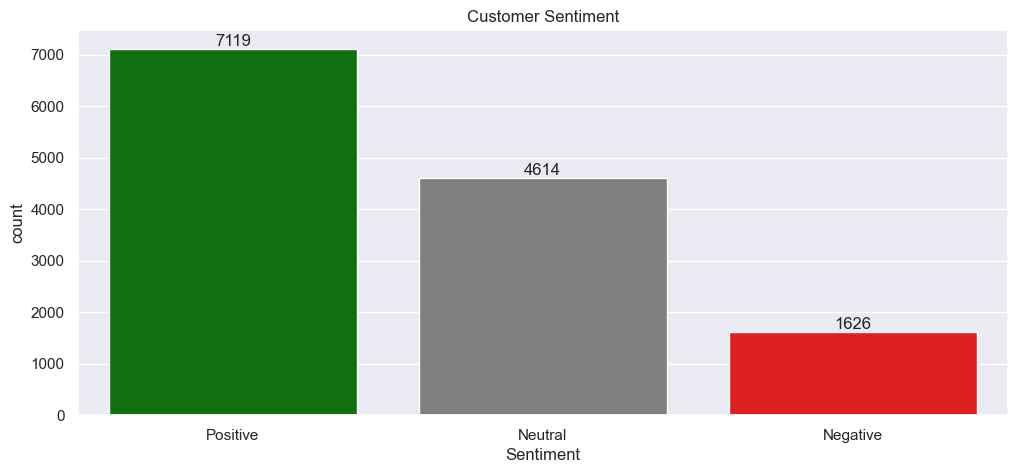

In [29]:
plt.figure(figsize=(12,5))
custom_palette = {"Positive": "green", "Neutral": "grey", "Negative": "red"}
ax = sns.countplot(df, x='Sentiment', palette=custom_palette)
val = df['Sentiment'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=val)
plt.title('Customer Sentiment');

**Insight:** <br>
**A total of 7119 customers hold a positive view towards the products, whereas 1626 customers have expressed their negative sentiment. The remaining 4614 customers have a neutral sentiment.**

## Customer Rating

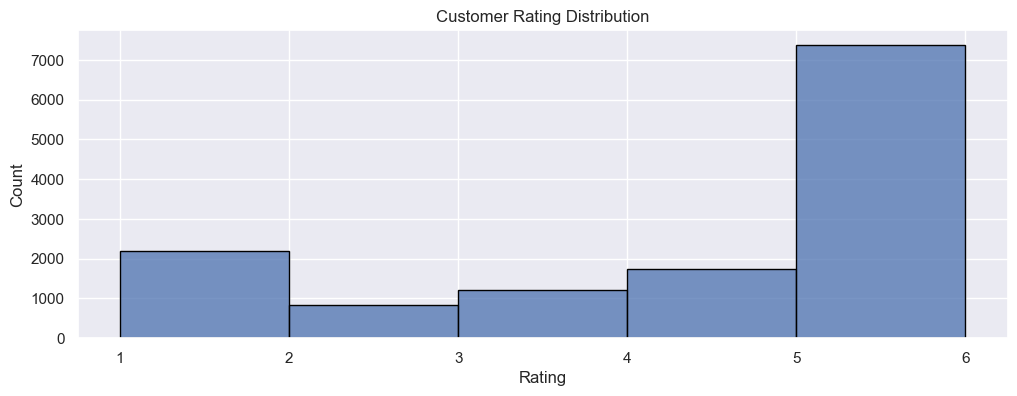

In [30]:
# Rating distribution
plt.figure(figsize=(12,4))
sns.histplot(x=df['Rating'], edgecolor='black', bins=[1,2,3,4,5,6])
plt.title('Customer Rating Distribution');

**Insight:** <br>
**Most customers rate products highly with high rating for 5 though there are significant rating 1 which represent negative view of products.**

## Product Category

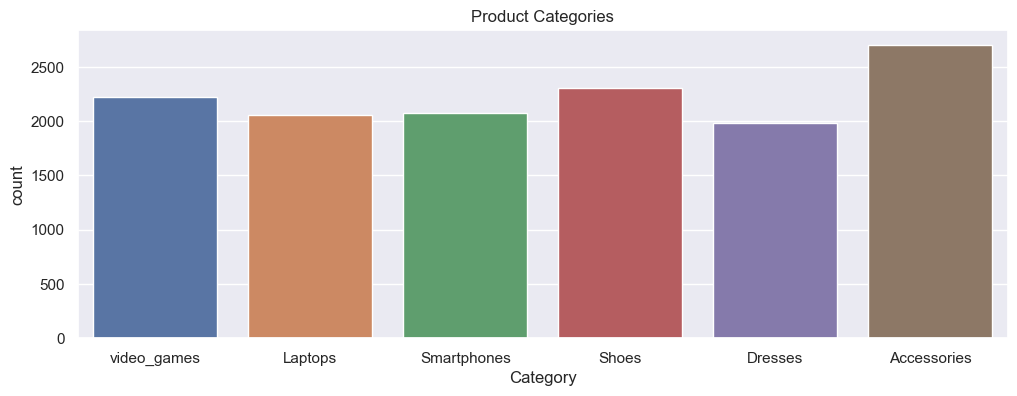

In [31]:
# Count of product categories
plt.figure(figsize=(12,4))
sns.countplot(data=df, x='Category')
plt.title('Product Categories');

**Insight:** <br>
**Accessories has most customer interaction, shoes and video_games, the remaining three categories of laptops, smartphones and dresses have similar customer interaction.**

## Day vs Review Count

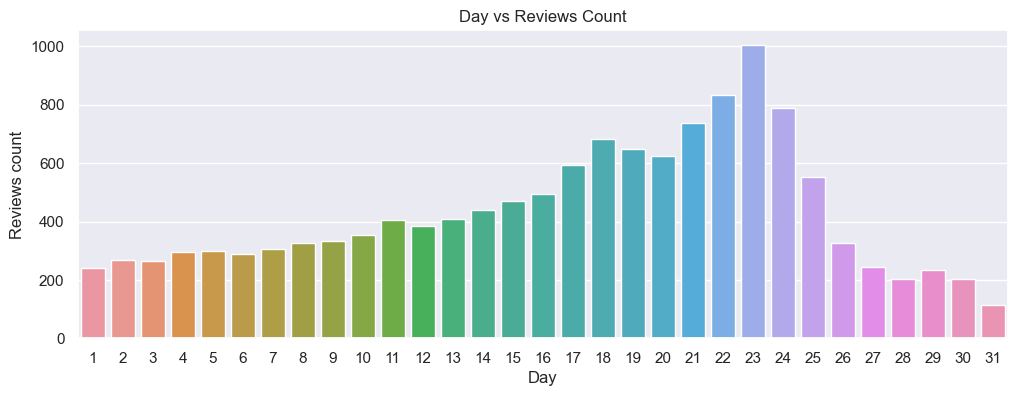

In [32]:
#Creating a dataframe
day=pd.DataFrame(df.groupby('Day')['Review'].count()).reset_index()
day['Day']=day['Day'].astype('int64')
day.sort_values(by=['Day'])

#Plotting the graph
plt.figure(figsize=(12,4))
sns.barplot(x="Day", y="Review", data=day)
plt.title('Day vs Reviews Count')
plt.xlabel('Day')
plt.ylabel('Reviews count');

**Insight:** <br>
**Customer reviews are high around the 17th to 24th days of the months but dwindle at the ending and beginning days of the month.**

## Sentiment Polarity Distribution

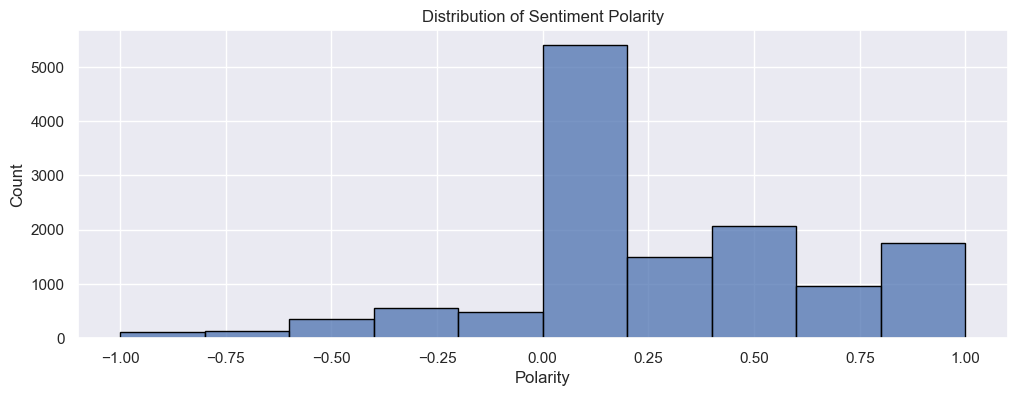

In [33]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x='Polarity', bins=10, edgecolor='black')
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Polarity')
plt.ylabel('Count');

**Insight:** <br>
**The polarity represent sentiment of customers, and this chart butress the customers positive view of products with the polartiy been positively skewed.**

## Review Text Length

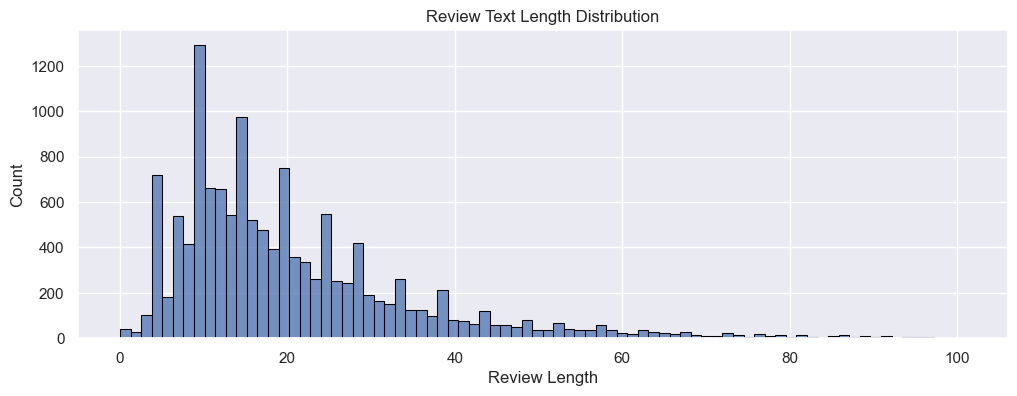

In [34]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x='Review_len', edgecolor='black')
plt.title('Review Text Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Count');

**Insight:** <br>
**Review text length is rightly skewed with customers usually review length usually falling between 0 and 60 letters count.**

## Review Text Word Count

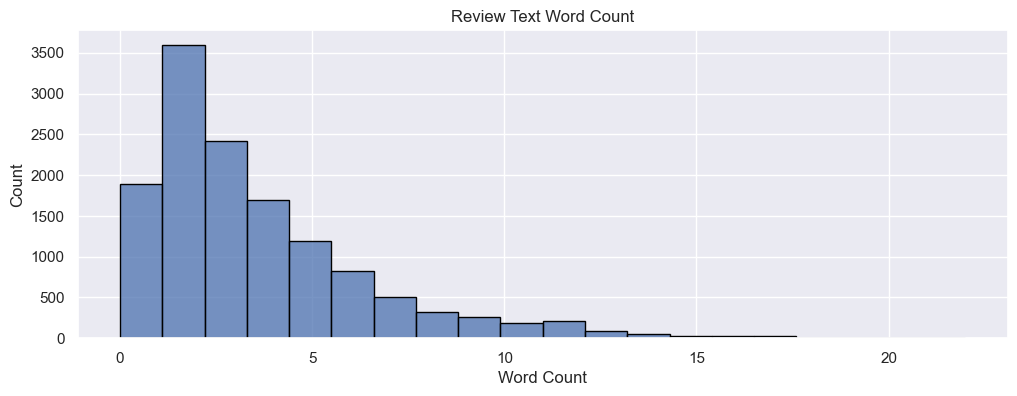

In [35]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x='Word_count', edgecolor='black', bins=20)
plt.title('Review Text Word Count')
plt.xlabel('Word Count')
plt.ylabel('Count');

**Insight:** <br>
**Review word count is rightly skewed with review words less than 20 among all customers.**

## N-gram Analysis
**Here we analyze text in the Review column based on Sentiment**

### Unigram Analysis
**Unigrams are single words, and each word in a text is considered independently.**

In [36]:
# Filter dataframe based on Sentiment labels
negative_reviews = df[df["Sentiment"] == "Negative"]
neutral_reviews = df[df["Sentiment"] == "Neutral"]
positive_reviews = df[df["Sentiment"] == "Positive"]

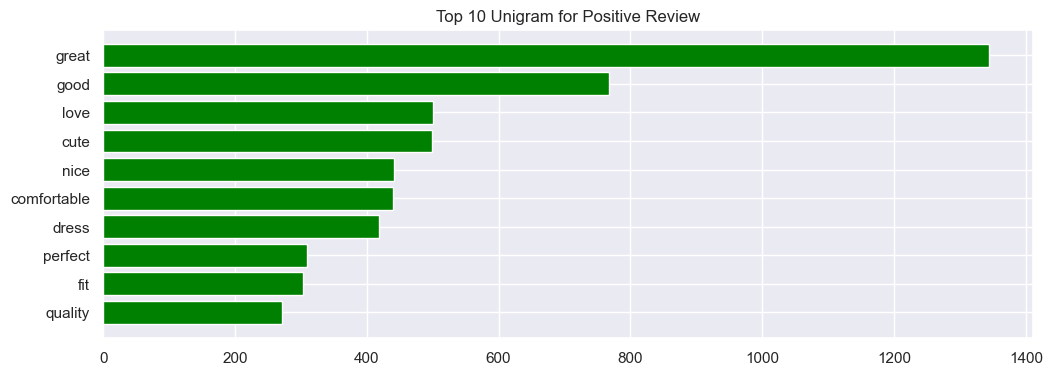

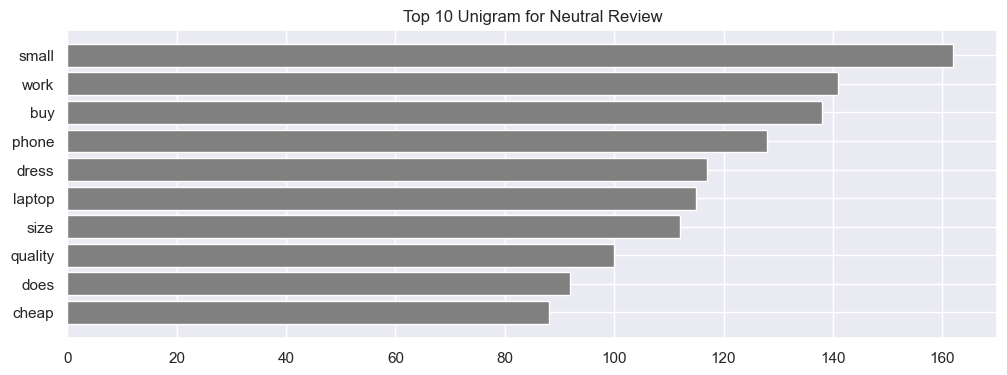

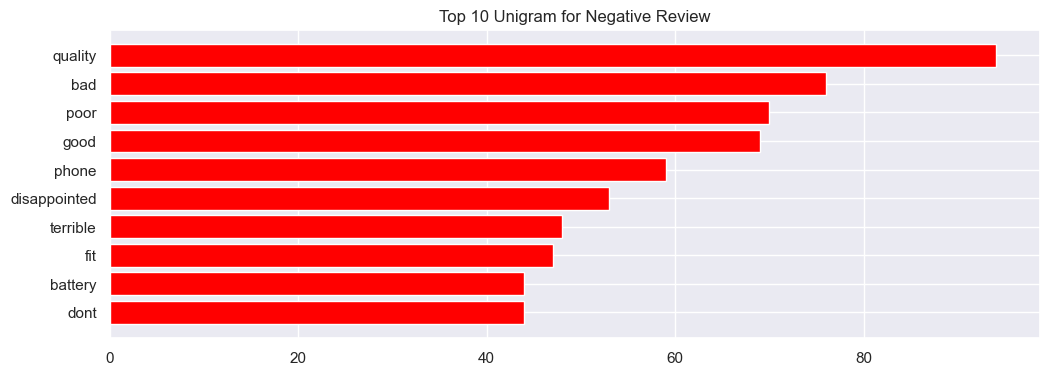

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_ngrams(reviews, ngram_range, num_top_ngrams=10, color='blue', title='Top 10'):
    ngram_vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngram_counts = ngram_vectorizer.fit_transform(reviews["Review"])

    ngram_names = ngram_vectorizer.get_feature_names_out()
    ngram_counts = ngram_counts.sum(axis=0).A1
    ngram_freq = dict(zip(ngram_names, ngram_counts))

    top_ngrams = Counter(ngram_freq)
    top_ngrams = top_ngrams.most_common(num_top_ngrams)

    ngram, count = zip(*top_ngrams)

    plt.figure(figsize=(12, 4))
    plt.barh(ngram[::-1], count[::-1], color=color)  # Reversed order and color customization
    plt.title(title)  # Customize the title
    plt.show()

# Customize colors and titles for each sentiment type
plot_ngrams(positive_reviews, (1, 1), num_top_ngrams=10, color='green', title='Top 10 Unigram for Positive Review')  # Positive
plot_ngrams(neutral_reviews, (1, 1), num_top_ngrams=10, color='grey', title='Top 10 Unigram for Neutral Review')  # Neutral
plot_ngrams(negative_reviews, (1, 1), num_top_ngrams=10, color='red', title='Top 10 Unigram for Negative Review')  # Negative

### Bigram Analysis
**Bigrams consist of two adjacent words in the text. They capture word pairs that occur together.**

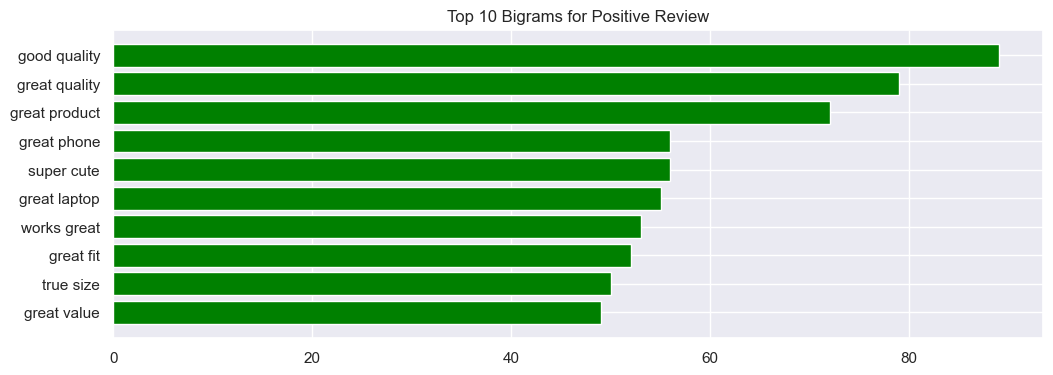

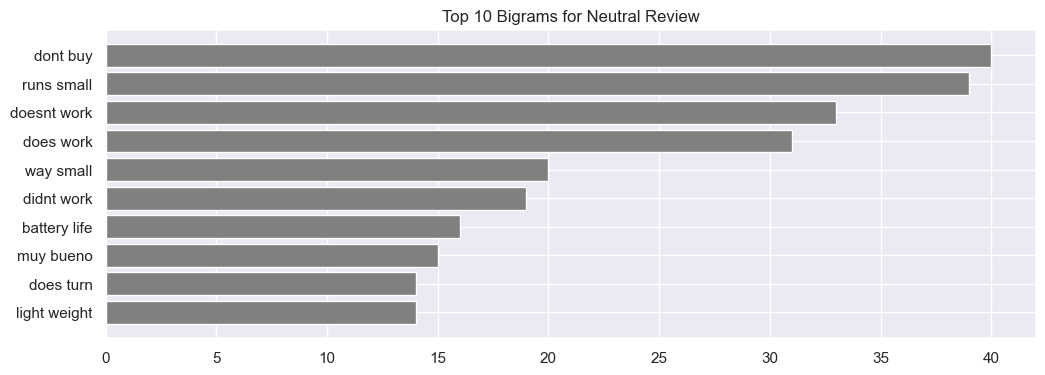

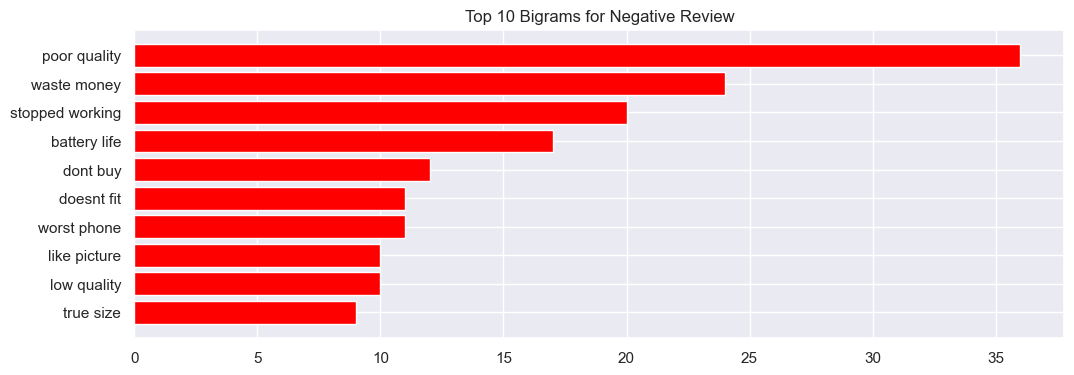

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_ngrams(reviews, ngram_range, num_top_ngrams=10, color='blue', title='Top 10'):
    ngram_vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngram_counts = ngram_vectorizer.fit_transform(reviews["Review"])

    ngram_names = ngram_vectorizer.get_feature_names_out()
    ngram_counts = ngram_counts.sum(axis=0).A1
    ngram_freq = dict(zip(ngram_names, ngram_counts))

    top_ngrams = Counter(ngram_freq)
    top_ngrams = top_ngrams.most_common(num_top_ngrams)

    ngram, count = zip(*top_ngrams)

    plt.figure(figsize=(12, 4))
    plt.barh(ngram[::-1], count[::-1], color=color)  # Reversed order and color customization
    plt.title(title)  # Customize the title
    plt.show()

# Customize colors and titles for each sentiment type
plot_ngrams(positive_reviews, (2, 2), num_top_ngrams=10, color='green', title='Top 10 Bigrams for Positive Review')  # Positive
plot_ngrams(neutral_reviews, (2, 2), num_top_ngrams=10, color='grey', title='Top 10 Bigrams for Neutral Review')  # Neutral
plot_ngrams(negative_reviews, (2, 2), num_top_ngrams=10, color='red', title='Top 10 Bigrams for Negative Review')  # Negative

### Trigram Analysis
**Trigrams consist of three adjacent words in the text. They capture triplets of words that often occur together.**

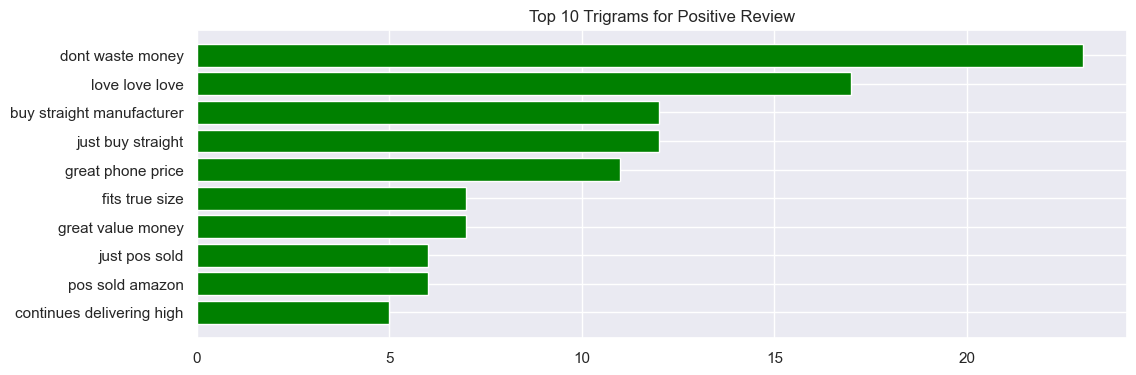

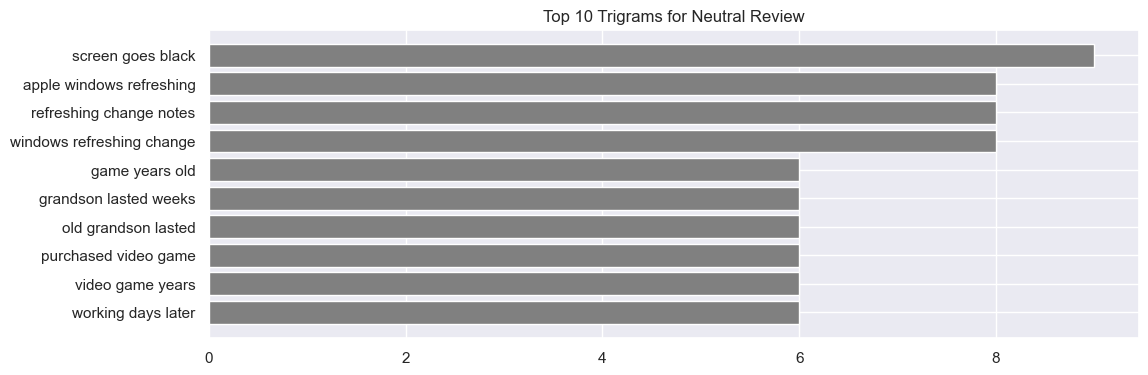

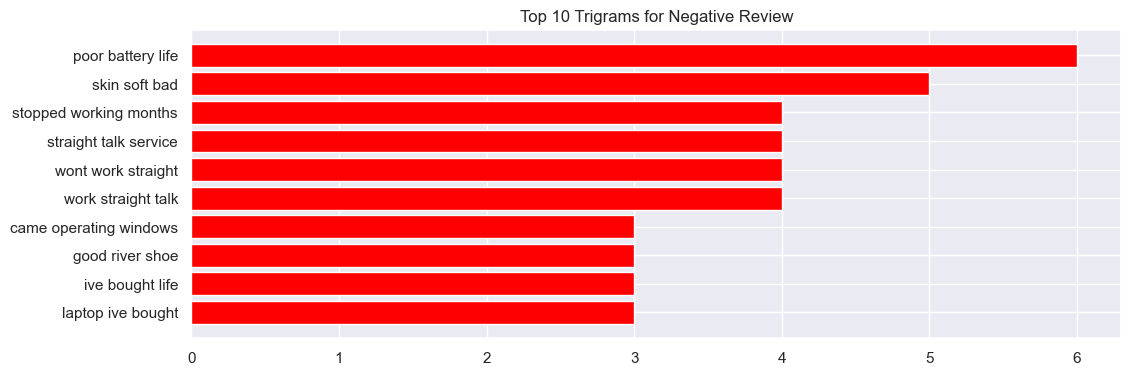

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_ngrams(reviews, ngram_range, num_top_ngrams=10, color='blue', title='Top 10'):
    ngram_vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngram_counts = ngram_vectorizer.fit_transform(reviews["Review"])

    ngram_names = ngram_vectorizer.get_feature_names_out()
    ngram_counts = ngram_counts.sum(axis=0).A1
    ngram_freq = dict(zip(ngram_names, ngram_counts))

    top_ngrams = Counter(ngram_freq)
    top_ngrams = top_ngrams.most_common(num_top_ngrams)

    ngram, count = zip(*top_ngrams)

    plt.figure(figsize=(12, 4))
    plt.barh(ngram[::-1], count[::-1], color=color)  # Reversed order and color customization
    plt.title(title)  # Customize the title
    plt.show()

# Customize colors and titles for each sentiment type
plot_ngrams(positive_reviews, (3, 3), num_top_ngrams=10, color='green', title='Top 10 Trigrams for Positive Review')  # Positive
plot_ngrams(neutral_reviews, (3, 3), num_top_ngrams=10, color='grey', title='Top 10 Trigrams for Neutral Review')  # Neutral
plot_ngrams(negative_reviews, (3, 3), num_top_ngrams=10, color='red', title='Top 10 Trigrams for Negative Review')  # Negative

## Wordcloud Analysis
**Here we visualize the text in customer reviews per sentiments. Most frequent words in review are displayed, with the size of each word in the word cloud proportional to its frequency.**

In [40]:
# Create text data for each sentiment category
positive_text = " ".join(positive_reviews["Review"])
neutral_text = " ".join(neutral_reviews["Review"])
negative_text = " ".join(negative_reviews["Review"])

## Wordcloud - Positive Review

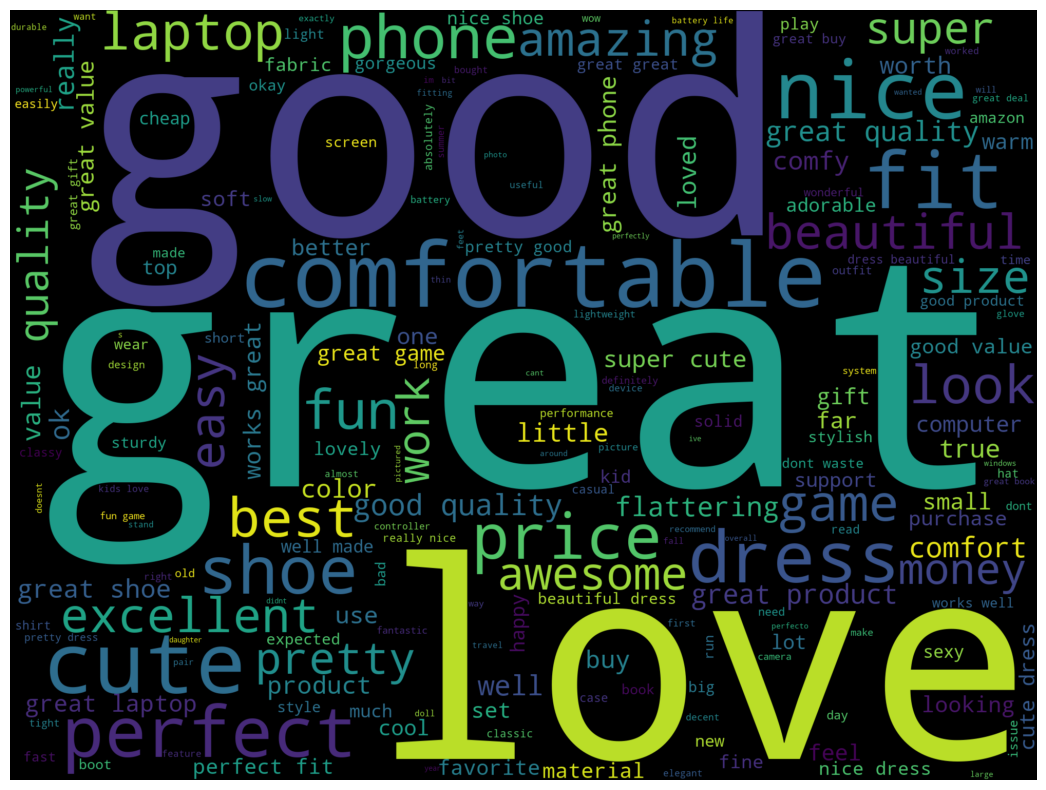

In [41]:
# Create and display word cloud for positive sentiment
wordcloud = WordCloud(width=2000, height=1500, background_color='black').generate(positive_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Wordcloud - Neutral Review

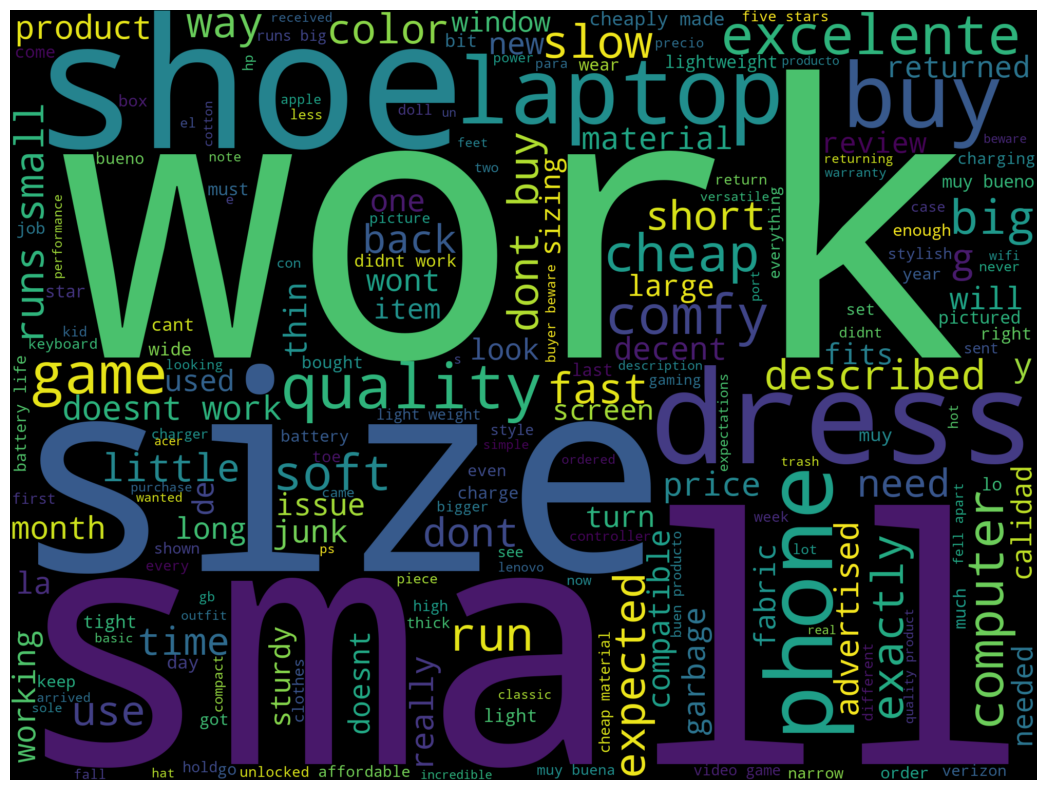

In [42]:
# Create and display word cloud for neutral sentiment
wordcloud = WordCloud(width=2000, height=1500, background_color='black').generate(neutral_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Wordcloud - Negative Review

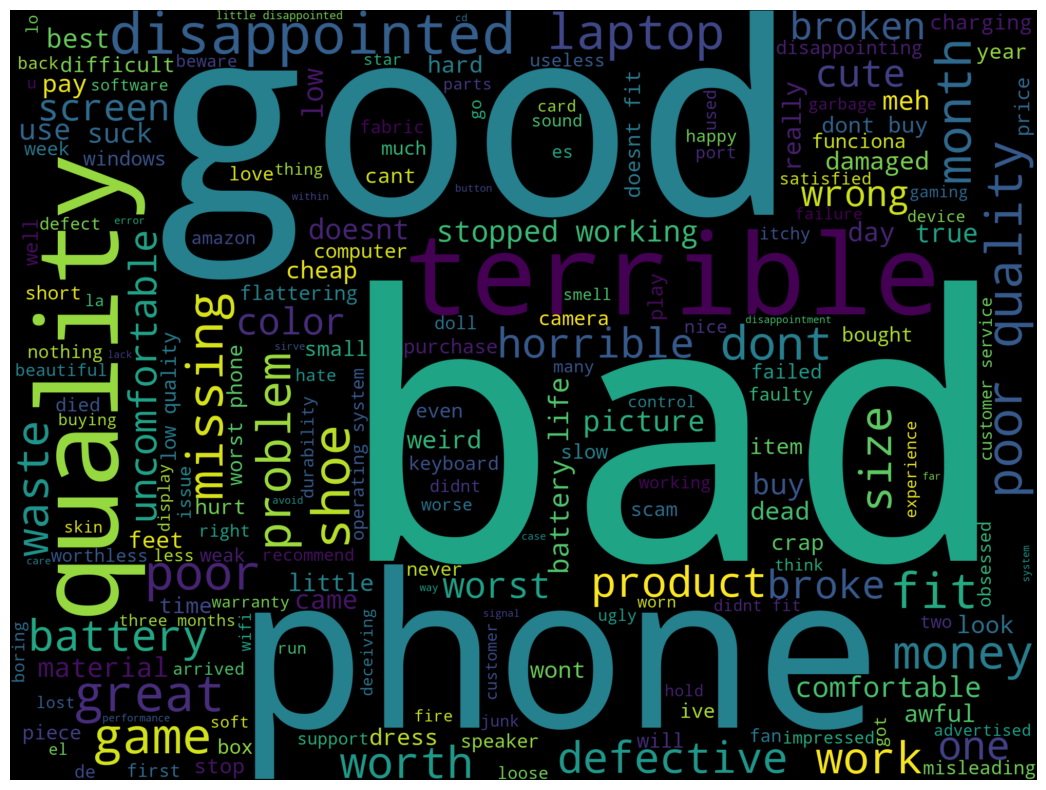

In [43]:
# Create and display word cloud for neutral sentiment
wordcloud = WordCloud(width=2000, height=1500, background_color='black').generate(negative_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<a id="Task-4"></a>
# 4. Features Extraction for Model Building

## Lemmatization Reviews
Lemmatization is the process of reducing words to their base or dictionary form (lemma). It aims to group together words with the same meaning.

Example:
- Lemmatization of the word "running" results in "run."
- Lemmatization of "better" gives "good," and "greatest" becomes "great." 

In [44]:
# Extracting 'reviews' for preprocessing
df = df.copy()
text = df[['Review']].reset_index(drop=True)
text[100:103]

,Review
100,a great format to get folks interested in game...
101,choice of entertainment
102,outdated


In [45]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [46]:
# Initialize the Lemmatizatizer
wn = WordNetLemmatizer()

corpus = []
for i in range(0, len(text)):
    review = re.sub('[^a-zA-Z]', ' ', text['Review'][i])
    review = review.split()
    
    review = [wn.lemmatize(word) for word in review if not word in (stop_words)]
    review = ' '.join(review)
    corpus.append(review)

In [47]:
corpus[100]

'great format get folk interested game history'

## Encoding Review text using Bag of Words (BoW)
The Bag of Words (BoW) method is a text analysis technique used to represent text data. It treats documents as an unordered collection of words and their frequencies, creating a numerical vector for each document. This approach is fundamental in Natural Language Processing and text analysis.

In BoW, text is tokenized, and a vocabulary of unique words is built. Each document's word frequency is counted and converted into a numerical format. The resulting matrix represents documents and their word frequencies. BoW simplifies text data for machine learning but lacks word order and context information.

In [48]:
# Creation of bag of words for Review
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus).toarray()

In [49]:
X.shape

(13359, 4538)

In [50]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Encoding target (sentiment) label

In [51]:
# Initialize label encoder
encoder = LabelEncoder()

# Use label encoder to transform sentiment
df['Target'] = encoder.fit_transform(df['Sentiment'])
df['Target'].unique()

array([2, 1, 0])

In [52]:
df['Target'].value_counts()

2    7119
1    4614
0    1626
Name: Target, dtype: int64

In [53]:
y = df['Target']

In [54]:
y.shape

(13359,)

## Handling Imbalance Target Feature - SMOTE
SMOTE, which stands for Synthetic Minority Over-sampling Technique, is a technique used in machine learning to address the class imbalance problem in a dataset. As in this case, where there is significant "positive" sentiment making majority class, while "neutral" and "negative" classes are the minority.

It works by doing the following: 1) SMOTE identify the minority class instances and selects k-nearest neighbors from the same class. 2) SMOTE generates synthetic examples for each instance in the minority class by creating convex combinations of the feature vectors of the instance and its k-nearest neighbors. These synthetic examples are then added to the dataset. 3) The dataset is now more balanced to train machine learning models without the bias introduced by the class imbalance.

In [55]:
# Instantiate SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Resample your dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

In [56]:
# Shape of Original and Resampled Target (y) label
print(f'Original dataset shape : {Counter(y)}')
print(f'Resampled dataset shape: {Counter(y_resampled)}')

Original dataset shape : Counter({2: 7119, 1: 4614, 0: 1626})
Resampled dataset shape: Counter({2: 7119, 1: 7119, 0: 7119})


## Splitting of dataset (75:25)

In [57]:
# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=0)

<a id="Task-5"></a>
# 5. Sentiment Model Building

## Model Selection
Using cross validation, the best performing algorithm is selected for the sentiment model building.

In [58]:
# Creating the objects
rf_cv = RandomForestClassifier(random_state=0)
knn_cv = KNeighborsClassifier()
logreg_cv = LogisticRegression(random_state=0)
nb_cv = MultinomialNB()
cv_dict = {0: 'Random Forest', 1:'KNN', 2:'Logistic Regression', 3:'Naive Bayes'}
cv_models = [rf_cv, knn_cv, logreg_cv, nb_cv]

for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i], cross_val_score(model, X, y, cv=5, scoring ='accuracy').mean()))

Random Forest Test Accuracy: 0.9321805004741547
KNN Test Accuracy: 0.8587467240733808
Logistic Regression Test Accuracy: 0.9244706674259119
Naive Bayes Test Accuracy: 0.8256593327758559


**From the above result, Random Forest Classifier performed best at an accuracy 93.2% on our dataset and therefore is selected for the sentiment model building.**

## Sentiment Model Building - Random Forest Classifier

In [59]:
# Training model with the best parameters
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)
model_pred = model.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.90


## Sentiment Model Evaluation

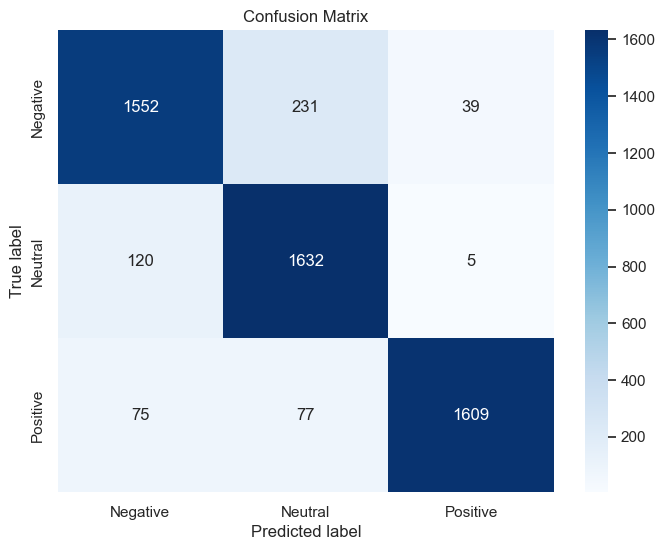

In [60]:
# Confusion matrix
cm = confusion_matrix(y_test, model_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

**The diagonal elements (1552 + 1632 + 1609) are the correctly predicted instances by the model and rest are incorrectly classified by the model.**

In [61]:
print("Classification Report:\n",classification_report(y_test, model_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      1822
           1       0.84      0.93      0.88      1757
           2       0.97      0.91      0.94      1761

    accuracy                           0.90      5340
   macro avg       0.90      0.90      0.90      5340
weighted avg       0.90      0.90      0.90      5340



**Considering the F1-score, the model performs well in distinguishing positive sentiment (94%), moderately well in identifying neutral sentiment (88%), and negative sentiment (87%).**

<a id="Task-6"></a>
# 6. Conclusion
---
**In this project, we undertook a series of tasks, including data preprocessing and feature engineering, sentiment classification based on customer ratings, exploratory data analysis, addressing data imbalance using SMOTE, and the development of a sentiment classification model. The project yielded valuable insights, which can be summarized as follows:**

**Introduction:**
- We conducted a project to understand customer sentiments on Amazon.com product reviews. Our goal was to uncover insights and improve customer experience.

**Data Preprocessing and Feature Engineering:**
- We cleaned the dataset, ensuring data quality.
- We created new features like sentiment polarity to gauge the emotional tone in reviews.

**Understanding Sentiments:**
- We analyzed customer reviews and identified three sentiment categories: positive, neutral, and negative.
- We explored the emotional tone of reviews, helping us understand customer feedback.

**Review Characteristics:**
- We looked into review length and word count, providing insights into customers' communication style.

**Keywords and Phrases:**
- We found that certain words and phrases strongly correlated with sentiments using n-gram analysis and word cloud visualization.

**Balancing Data:**
- We tackled data imbalance issues by applying a technique called SMOTE, improving the model's ability to learn from positive, neutral and negative sentiments.

**Model Building and Performance:**
- We developed a model to automatically classify sentiments in reviews.
- The model achieved a 90% accuracy rate, suggesting a good balance between precision and recall, which contributes to accurate predictions.

**Key Takeaways:**
- Our findings offer insights into customer feedback, which can be valuable for product improvements.
- Understanding customer sentiments is essential for enhancing customer satisfaction.

**Conclusion:**
- Our project equips businesses with tools to gain deeper insights from customer reviews, leading to better products and services.